In [1]:
import numpy as np
import pandas as pd 

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
from keras import regularizers

In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:
# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("2.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 0
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

print("Summary of dataGene:\n",dataGene.describe())

Summary of dataGene:
        log_2FoldChange            ET  CoExpression           PCC  \
count     41110.000000  41110.000000  41110.000000  41110.000000   
mean         -0.037332      1.407395      0.991997     -0.361737   
std           0.391444      0.784327      0.089101      0.463979   
min          -1.000000      0.000000      0.000000     -1.000000   
25%          -0.251534      1.000000      1.000000     -0.747963   
50%           0.030675      2.000000      1.000000     -0.449089   
75%           0.251534      2.000000      1.000000     -0.051646   
max           1.000000      2.000000      1.000000      1.000000   

                PPI  Root10DaysSeedling  Root14DaysSeedling  \
count  41110.000000        41110.000000        41110.000000   
mean       0.914668           -0.522040           -0.646982   
std        0.279379            0.498568            0.393549   
min        0.000000           -1.000000           -1.000000   
25%        1.000000           -0.901371           

In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in PCC feature selection method
feature_names = ['CoExpression', 'PCC', 'PPI', 'Root10DaysSeedling', 'Leaf21DaysSeedling',
                 'Leaf45DaysOldPlant', 'log_2FoldChange', 'ET', 'Shoot10DaysSeedling', 'Shoot3DaysSeedling', 
                 'Shoot35DaysSeedling', 'Shoot14DaysSeedling', 'Root17DaysSeedling', 'Shoot17DaysSeedling', 'Shoot21DaysSeedling',
                 'Root24DaysSeedling', 'Root14DaysSeedling', 'Root21DaysSeedling', 'Root52DaysSeedling', 'Root35DaysSeedling']

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
print("Summary of X:\n",X_fs.describe())
print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray

X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)


Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
Summary of X:
        CoExpression           PCC           PPI  Root10DaysSeedling  \
count  41110.000000  41110.000000  41110.000000        41110.000000   
mean       0.991997     -0.361737      0.914668           -0.522040   
std        0.089101      0.463979      0.279379            0.498568   
min        0.000000     -1.000000      0.000000           -1.000000   
25%        1.000000     -0.747963      1.000000           -0.901371   
50%        1.000000     -0.449089      1.000000           -0.663664   
75%        1.000000     -0.051646      1.000000           -0.378497   
max        1.000000      1.000000      1.000000            1.000000   

       Leaf21DaysSeedling  Leaf45DaysOldPlant  log_2FoldChange            ET  \
count        41110.000000        41110.000000     41110.000000  41110.000000   
mean            -0.828778           -0.585144        -0.037332      1.407395   
std              0.327542            0.399046         0.39

Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

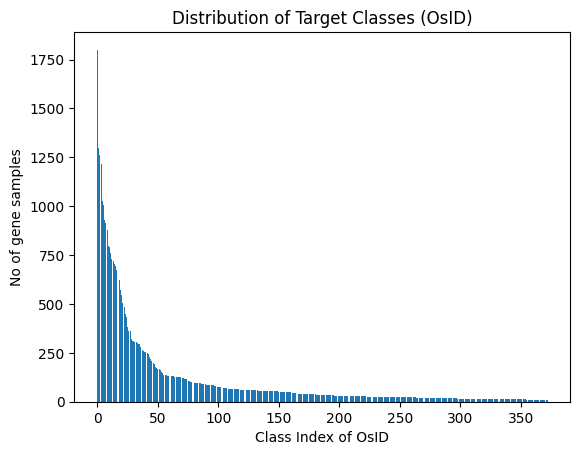

In [5]:
from collections import Counter
# summarize distribution
counter = Counter(Y.flatten())

# sort counter by keys
counter = dict(sorted(counter.items()))

for k,v in counter.items():
 per = v / len(Y.flatten()) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
def draw_confusion_matrix(cm):
    plt.figure(figsize=(12,8))
    sns.heatmap(cm,annot=True,fmt="d", center=0, cmap='autumn') 
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [7]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [8]:
# define baseline model (MLP)
def MLP_model(input_dim):

    model = Sequential()
    model.add(Dense(60, input_dim=input_dim,bias_initializer='normal', activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal', activation='softmax')) #softmax for multi-class classification, num_classes = 373

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [9]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = MLP_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=20, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

Number of input features: 1
Fold: 1
Epoch 1/20
1846/1846 [==============================] - 9s 4ms/step - loss: 5.0754 - accuracy: 0.0425 - val_loss: 5.0166 - val_accuracy: 0.0451
Epoch 2/20
1846/1846 [==============================] - 4s 2ms/step - loss: 4.9463 - accuracy: 0.0454 - val_loss: 5.0037 - val_accuracy: 0.0451
Epoch 3/20
1846/1846 [==============================] - 5s 3ms/step - loss: 4.9323 - accuracy: 0.0453 - val_loss: 5.0030 - val_accuracy: 0.0451
Epoch 4/20
1846/1846 [==============================] - 4s 2ms/step - loss: 4.9294 - accuracy: 0.0448 - val_loss: 4.9953 - val_accuracy: 0.0451
Epoch 5/20
1846/1846 [==============================] - 6s 3ms/step - loss: 4.9268 - accuracy: 0.0453 - val_loss: 5.0019 - val_accuracy: 0.0451
Epoch 6/20
1846/1846 [==============================] - 6s 3ms/step - loss: 4.9245 - accuracy: 0.0453 - val_loss: 5.0077 - val_accuracy: 0.0451
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 4.9240 - accuracy: 0.045

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 22s 9ms/step - loss: 5.0638 - accuracy: 0.0444 - val_loss: 4.9754 - val_accuracy: 0.0510
Epoch 2/20
1846/1846 [==============================] - 18s 10ms/step - loss: 4.8790 - accuracy: 0.0535 - val_loss: 4.9109 - val_accuracy: 0.0517
Epoch 3/20
1846/1846 [==============================] - 16s 9ms/step - loss: 4.8203 - accuracy: 0.0547 - val_loss: 4.9307 - val_accuracy: 0.0517
Epoch 4/20
1846/1846 [==============================] - 21s 11ms/step - loss: 4.7877 - accuracy: 0.0572 - val_loss: 4.8857 - val_accuracy: 0.0482
Epoch 5/20
1846/1846 [==============================] - 16s 9ms/step - loss: 4.7684 - accuracy: 0.0600 - val_loss: 4.8893 - val_accuracy: 0.0559
Epoch 6/20
1846/1846 [==============================] - 12s 7ms/step - loss: 4.7536 - accuracy: 0.0594 - val_loss: 4.8879 - val_accuracy: 0.0561
Epoch 7/20
1846/1846 [==============================] - 12s 7ms/step - loss: 4.7368 - accuracy: 0.0613 - val_loss: 4.9014 - val_

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 11s 4ms/step - loss: 4.8938 - accuracy: 0.0767 - val_loss: 4.7439 - val_accuracy: 0.0772
Epoch 2/20
1846/1846 [==============================] - 7s 4ms/step - loss: 4.6348 - accuracy: 0.0838 - val_loss: 4.6980 - val_accuracy: 0.0785
Epoch 3/20
1846/1846 [==============================] - 8s 4ms/step - loss: 4.5803 - accuracy: 0.0848 - val_loss: 4.6661 - val_accuracy: 0.0772
Epoch 4/20
1846/1846 [==============================] - 8s 4ms/step - loss: 4.5466 - accuracy: 0.0854 - val_loss: 4.6687 - val_accuracy: 0.0788
Epoch 5/20
1846/1846 [==============================] - 8s 4ms/step - loss: 4.5179 - accuracy: 0.0857 - val_loss: 4.6414 - val_accuracy: 0.0790
Epoch 6/20
1846/1846 [==============================] - 8s 4ms/step - loss: 4.4977 - accuracy: 0.0861 - val_loss: 4.6702 - val_accuracy: 0.0752
Epoch 7/20
1846/1846 [==============================] - 8s 4ms/step - loss: 4.4819 - accuracy: 0.0868 - val_loss: 4.6346 - val_accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 11s 5ms/step - loss: 4.4312 - accuracy: 0.1275 - val_loss: 3.9421 - val_accuracy: 0.1943
Epoch 2/20
1846/1846 [==============================] - 8s 4ms/step - loss: 3.5189 - accuracy: 0.2202 - val_loss: 3.4162 - val_accuracy: 0.2332
Epoch 3/20
1846/1846 [==============================] - 8s 4ms/step - loss: 3.0758 - accuracy: 0.2821 - val_loss: 3.1074 - val_accuracy: 0.3153
Epoch 4/20
1846/1846 [==============================] - 8s 4ms/step - loss: 2.7908 - accuracy: 0.3311 - val_loss: 2.9172 - val_accuracy: 0.3241
Epoch 5/20
1846/1846 [==============================] - 8s 4ms/step - loss: 2.5876 - accuracy: 0.3554 - val_loss: 2.7488 - val_accuracy: 0.3573
Epoch 6/20
1846/1846 [==============================] - 8s 4ms/step - loss: 2.4309 - accuracy: 0.3814 - val_loss: 2.6558 - val_accuracy: 0.3395
Epoch 7/20
1846/1846 [==============================] - 8s 4ms/step - loss: 2.3150 - accuracy: 0.3950 - val_loss: 2.5919 - val_accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 10s 4ms/step - loss: 4.3353 - accuracy: 0.1325 - val_loss: 3.8964 - val_accuracy: 0.1881
Epoch 2/20
1846/1846 [==============================] - 8s 4ms/step - loss: 3.4055 - accuracy: 0.2429 - val_loss: 3.2178 - val_accuracy: 0.3122
Epoch 3/20
1846/1846 [==============================] - 8s 4ms/step - loss: 2.7651 - accuracy: 0.3535 - val_loss: 2.7409 - val_accuracy: 0.3608
Epoch 4/20
1846/1846 [==============================] - 8s 4ms/step - loss: 2.3451 - accuracy: 0.4105 - val_loss: 2.4129 - val_accuracy: 0.3813
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 2.0598 - accuracy: 0.4677 - val_loss: 2.2007 - val_accuracy: 0.4893
Epoch 6/20
1846/1846 [==============================] - 8s 4ms/step - loss: 1.8651 - accuracy: 0.4998 - val_loss: 2.0391 - val_accuracy: 0.4944
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.7135 - accuracy: 0.5313 - val_loss: 1.9056 - val_accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 11s 4ms/step - loss: 3.9872 - accuracy: 0.2185 - val_loss: 3.2254 - val_accuracy: 0.3289
Epoch 2/20
1846/1846 [==============================] - 7s 4ms/step - loss: 2.5459 - accuracy: 0.4553 - val_loss: 2.3111 - val_accuracy: 0.5591
Epoch 3/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.7972 - accuracy: 0.5986 - val_loss: 1.8103 - val_accuracy: 0.6559
Epoch 4/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.3962 - accuracy: 0.6658 - val_loss: 1.5129 - val_accuracy: 0.6788
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.1584 - accuracy: 0.7043 - val_loss: 1.3728 - val_accuracy: 0.7105
Epoch 6/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.0097 - accuracy: 0.7325 - val_loss: 1.2205 - val_accuracy: 0.7399
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.9122 - accuracy: 0.7514 - val_loss: 1.1393 - val_accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 11s 4ms/step - loss: 4.1049 - accuracy: 0.2207 - val_loss: 3.3237 - val_accuracy: 0.3397
Epoch 2/20
1846/1846 [==============================] - 7s 4ms/step - loss: 2.6672 - accuracy: 0.4522 - val_loss: 2.4420 - val_accuracy: 0.4948
Epoch 3/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.9003 - accuracy: 0.5791 - val_loss: 1.9058 - val_accuracy: 0.6136
Epoch 4/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.4055 - accuracy: 0.6728 - val_loss: 1.5216 - val_accuracy: 0.7006
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.0885 - accuracy: 0.7253 - val_loss: 1.3029 - val_accuracy: 0.7426
Epoch 6/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.8823 - accuracy: 0.7639 - val_loss: 1.1652 - val_accuracy: 0.7648
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.7550 - accuracy: 0.7920 - val_loss: 1.0406 - val_accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 10s 4ms/step - loss: 3.9437 - accuracy: 0.2118 - val_loss: 2.9470 - val_accuracy: 0.4293
Epoch 2/20
1846/1846 [==============================] - 7s 4ms/step - loss: 2.2758 - accuracy: 0.4904 - val_loss: 2.0766 - val_accuracy: 0.5723
Epoch 3/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.5679 - accuracy: 0.6201 - val_loss: 1.6061 - val_accuracy: 0.6519
Epoch 4/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.2095 - accuracy: 0.6864 - val_loss: 1.3261 - val_accuracy: 0.7065
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.9967 - accuracy: 0.7271 - val_loss: 1.1350 - val_accuracy: 0.7547
Epoch 6/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.8565 - accuracy: 0.7563 - val_loss: 1.0100 - val_accuracy: 0.7820
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.7623 - accuracy: 0.7746 - val_loss: 0.9629 - val_accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 10s 4ms/step - loss: 3.6504 - accuracy: 0.2904 - val_loss: 2.5217 - val_accuracy: 0.5102
Epoch 2/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.7860 - accuracy: 0.6299 - val_loss: 1.6183 - val_accuracy: 0.6845
Epoch 3/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.1285 - accuracy: 0.7411 - val_loss: 1.1381 - val_accuracy: 0.7822
Epoch 4/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.7993 - accuracy: 0.7985 - val_loss: 0.8899 - val_accuracy: 0.8119
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.6377 - accuracy: 0.8284 - val_loss: 0.7907 - val_accuracy: 0.8436
Epoch 6/20
1846/1846 [==============================] - 8s 4ms/step - loss: 0.5527 - accuracy: 0.8487 - val_loss: 0.7054 - val_accuracy: 0.8528
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.4879 - accuracy: 0.8584 - val_loss: 0.6909 - val_accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 10s 4ms/step - loss: 3.7867 - accuracy: 0.2657 - val_loss: 2.5359 - val_accuracy: 0.5351
Epoch 2/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.7376 - accuracy: 0.6636 - val_loss: 1.4887 - val_accuracy: 0.7287
Epoch 3/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.0193 - accuracy: 0.7896 - val_loss: 1.0286 - val_accuracy: 0.8251
Epoch 4/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.6882 - accuracy: 0.8432 - val_loss: 0.8400 - val_accuracy: 0.8546
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.5136 - accuracy: 0.8783 - val_loss: 0.7550 - val_accuracy: 0.8559
Epoch 6/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.4142 - accuracy: 0.8953 - val_loss: 0.6437 - val_accuracy: 0.8805
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.3589 - accuracy: 0.9057 - val_loss: 0.5499 - val_accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 10s 4ms/step - loss: 3.6500 - accuracy: 0.2876 - val_loss: 2.5465 - val_accuracy: 0.5215
Epoch 2/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.7161 - accuracy: 0.6826 - val_loss: 1.4981 - val_accuracy: 0.7454
Epoch 3/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.9810 - accuracy: 0.8148 - val_loss: 1.0996 - val_accuracy: 0.8172
Epoch 4/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.6529 - accuracy: 0.8655 - val_loss: 0.8484 - val_accuracy: 0.8777
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.4731 - accuracy: 0.8953 - val_loss: 0.7221 - val_accuracy: 0.8931
Epoch 6/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.3637 - accuracy: 0.9155 - val_loss: 0.6602 - val_accuracy: 0.9083
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.3039 - accuracy: 0.9258 - val_loss: 0.5750 - val_accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 10s 4ms/step - loss: 3.5096 - accuracy: 0.3323 - val_loss: 2.2086 - val_accuracy: 0.5864
Epoch 2/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.4109 - accuracy: 0.7447 - val_loss: 1.2306 - val_accuracy: 0.7974
Epoch 3/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.7877 - accuracy: 0.8465 - val_loss: 0.8898 - val_accuracy: 0.8471
Epoch 4/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.5210 - accuracy: 0.8875 - val_loss: 0.6886 - val_accuracy: 0.8792
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.4004 - accuracy: 0.9043 - val_loss: 0.6011 - val_accuracy: 0.8957
Epoch 6/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.3278 - accuracy: 0.9202 - val_loss: 0.5276 - val_accuracy: 0.9201
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.2880 - accuracy: 0.9281 - val_loss: 0.4768 - val_accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 10s 4ms/step - loss: 3.4809 - accuracy: 0.3507 - val_loss: 2.1556 - val_accuracy: 0.6220
Epoch 2/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.4085 - accuracy: 0.7475 - val_loss: 1.2209 - val_accuracy: 0.7958
Epoch 3/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.7758 - accuracy: 0.8438 - val_loss: 0.8620 - val_accuracy: 0.8480
Epoch 4/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.5044 - accuracy: 0.8892 - val_loss: 0.6663 - val_accuracy: 0.8924
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.3696 - accuracy: 0.9148 - val_loss: 0.5721 - val_accuracy: 0.9113
Epoch 6/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.2967 - accuracy: 0.9248 - val_loss: 0.5187 - val_accuracy: 0.9223
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.2529 - accuracy: 0.9367 - val_loss: 0.4526 - val_accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 10s 4ms/step - loss: 3.7709 - accuracy: 0.2891 - val_loss: 2.5095 - val_accuracy: 0.5861
Epoch 2/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.6290 - accuracy: 0.7069 - val_loss: 1.3752 - val_accuracy: 0.7703
Epoch 3/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.8963 - accuracy: 0.8330 - val_loss: 0.9909 - val_accuracy: 0.8495
Epoch 4/20
1846/1846 [==============================] - 8s 4ms/step - loss: 0.5701 - accuracy: 0.8865 - val_loss: 0.7625 - val_accuracy: 0.8825
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.4021 - accuracy: 0.9133 - val_loss: 0.6155 - val_accuracy: 0.9072
Epoch 6/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.3175 - accuracy: 0.9267 - val_loss: 0.5351 - val_accuracy: 0.9325
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.2580 - accuracy: 0.9392 - val_loss: 0.4949 - val_accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 10s 4ms/step - loss: 3.4785 - accuracy: 0.3421 - val_loss: 2.2216 - val_accuracy: 0.6156
Epoch 2/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.4920 - accuracy: 0.7282 - val_loss: 1.3135 - val_accuracy: 0.7628
Epoch 3/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.8596 - accuracy: 0.8269 - val_loss: 0.8817 - val_accuracy: 0.8515
Epoch 4/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.5486 - accuracy: 0.8795 - val_loss: 0.6768 - val_accuracy: 0.8854
Epoch 5/20
1846/1846 [==============================] - 8s 4ms/step - loss: 0.3994 - accuracy: 0.9034 - val_loss: 0.5983 - val_accuracy: 0.8862
Epoch 6/20
1846/1846 [==============================] - 8s 4ms/step - loss: 0.3210 - accuracy: 0.9203 - val_loss: 0.5429 - val_accuracy: 0.8975
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.2668 - accuracy: 0.9312 - val_loss: 0.4275 - val_accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 14s 6ms/step - loss: 3.2463 - accuracy: 0.3961 - val_loss: 1.9484 - val_accuracy: 0.6702
Epoch 2/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.2519 - accuracy: 0.7680 - val_loss: 1.0664 - val_accuracy: 0.8046
Epoch 3/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.6604 - accuracy: 0.8665 - val_loss: 0.7673 - val_accuracy: 0.8667
Epoch 4/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.4111 - accuracy: 0.9118 - val_loss: 0.5487 - val_accuracy: 0.9078
Epoch 5/20
1846/1846 [==============================] - 8s 4ms/step - loss: 0.3085 - accuracy: 0.9297 - val_loss: 0.4856 - val_accuracy: 0.9248
Epoch 6/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.2482 - accuracy: 0.9410 - val_loss: 0.4089 - val_accuracy: 0.9402
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.2219 - accuracy: 0.9467 - val_loss: 0.3763 - val_accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 10s 4ms/step - loss: 3.4707 - accuracy: 0.3515 - val_loss: 2.2366 - val_accuracy: 0.5976
Epoch 2/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.5331 - accuracy: 0.7153 - val_loss: 1.3375 - val_accuracy: 0.7725
Epoch 3/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.8812 - accuracy: 0.8160 - val_loss: 0.9180 - val_accuracy: 0.8374
Epoch 4/20
1846/1846 [==============================] - 8s 4ms/step - loss: 0.5666 - accuracy: 0.8726 - val_loss: 0.7535 - val_accuracy: 0.8616
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.4221 - accuracy: 0.8956 - val_loss: 0.5895 - val_accuracy: 0.8964
Epoch 6/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.3339 - accuracy: 0.9157 - val_loss: 0.4858 - val_accuracy: 0.9164
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.2894 - accuracy: 0.9238 - val_loss: 0.4327 - val_accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 10s 4ms/step - loss: 3.3212 - accuracy: 0.3837 - val_loss: 2.0905 - val_accuracy: 0.6466
Epoch 2/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.3992 - accuracy: 0.7360 - val_loss: 1.2052 - val_accuracy: 0.7943
Epoch 3/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.8164 - accuracy: 0.8323 - val_loss: 0.9534 - val_accuracy: 0.8213
Epoch 4/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.5563 - accuracy: 0.8728 - val_loss: 0.6830 - val_accuracy: 0.8719
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.4244 - accuracy: 0.8941 - val_loss: 0.5859 - val_accuracy: 0.8939
Epoch 6/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.3484 - accuracy: 0.9122 - val_loss: 0.5646 - val_accuracy: 0.8972
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.2860 - accuracy: 0.9303 - val_loss: 0.5062 - val_accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 10s 4ms/step - loss: 3.4022 - accuracy: 0.3664 - val_loss: 2.0025 - val_accuracy: 0.6528
Epoch 2/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.2757 - accuracy: 0.7588 - val_loss: 1.0746 - val_accuracy: 0.8106
Epoch 3/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.6713 - accuracy: 0.8478 - val_loss: 0.7162 - val_accuracy: 0.8675
Epoch 4/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.4307 - accuracy: 0.8977 - val_loss: 0.5673 - val_accuracy: 0.8845
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.3316 - accuracy: 0.9132 - val_loss: 0.4681 - val_accuracy: 0.9094
Epoch 6/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.2769 - accuracy: 0.9287 - val_loss: 0.4048 - val_accuracy: 0.9245
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.2391 - accuracy: 0.9381 - val_loss: 0.3502 - val_accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 10s 4ms/step - loss: 3.3689 - accuracy: 0.3669 - val_loss: 2.1104 - val_accuracy: 0.6304
Epoch 2/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.3359 - accuracy: 0.7462 - val_loss: 1.0893 - val_accuracy: 0.7971
Epoch 3/20
1846/1846 [==============================] - 8s 4ms/step - loss: 0.6971 - accuracy: 0.8503 - val_loss: 0.7169 - val_accuracy: 0.8689
Epoch 4/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.4367 - accuracy: 0.9011 - val_loss: 0.5551 - val_accuracy: 0.9111
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.3169 - accuracy: 0.9249 - val_loss: 0.4466 - val_accuracy: 0.9265
Epoch 6/20
1846/1846 [==============================] - 8s 4ms/step - loss: 0.2540 - accuracy: 0.9393 - val_loss: 0.4062 - val_accuracy: 0.9287
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.2115 - accuracy: 0.9498 - val_loss: 0.3988 - val_accuracy

In [10]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

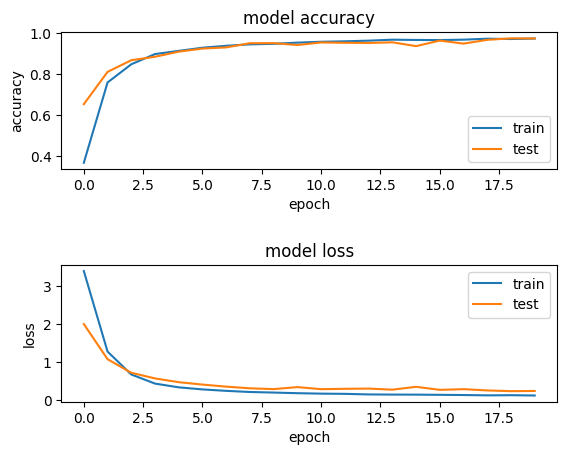

Final Test Accuracy: 0.9783297777175903


In [11]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [12]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))


424/424 [==============================] - 2s 2ms/step
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00       419
           3       1.00      1.00      1.00       384
           4       1.00      1.00      1.00       339
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       1.00      1.00      1.00       294
           9       1.00      1.00      1.00       269
          10       1.00      1.00      1.00       296
          11       1.00      1.00      1.00       258
          12       1.00      1.00      1.00       247
          13       1.00      1.00      1.00       237
          14       0.98      1.00      0.99       239
          15       1.00      1.00      1.00       235
  

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os11g0704500         328              328        True
1  Os09g0279600         161              161        True
2  Os03g0669100          17               17        True
3  Os05g0542500          34               34        True
4  Os09g0522000           7                7        True
